# Here i want to extract from lichess data features important for future modeling

So here i want to get data in format similar to that: 

columns = ( date, amount of mathes played in that date,ammont of matches played day earllier , amount of matches plyed for previous mounth, ranikng points fluctuation (day vs day before), ranking after last match that day, mean oponent vs my ranking diff that day ) and maybe some other columns that i will consider as important for ranking changes prediction. --> df2

And all of those for different times control (blitz, rapid, bullet)

and other data for winner prediction models, similar columns as without any chnages but some new cols like: time used in game, time for move and maybe some other --> df1

# To Be Continued

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
# Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
# Clasification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score
# Best_searches
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Standarization
from sklearn.preprocessing import StandardScaler

from keras import models
from keras.layers import Dense

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd
import numpy as np
import arrow
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv("Chess_data_basic.csv", index_col = "Unnamed: 0")

In [5]:
len(set(df["black_player_name"]+df["white_player_name"]))

4789

In [6]:
df.isna().sum()

id                     0
rated                  0
variant                0
speed                  0
createdAt              0
lastMoveAt             0
status                 0
winner               250
moves                  1
clock                  0
movesperplayer         0
white_player_name      0
white_ranking          0
black_player_name      0
black_ranking          0
dtype: int64

In [7]:
def convert_date_with_offset(date_str):
    return arrow.get(date_str).datetime

for i in ['createdAt', 'lastMoveAt']:
    df[i] = df[i].apply(convert_date_with_offset)
    
# Create Gametime column
df["Gametime"] = df["lastMoveAt"] - df["createdAt"]
# Handle Gametime column
df['Gametime'] = pd.to_timedelta(df['Gametime'])

rounding = lambda x: round(x, 1)

df['Gametime'] = df['Gametime'].dt.total_seconds().apply(rounding)
df['timepermove']=(df['Gametime']/df["movesperplayer"]).apply(rounding)

next think to do is taking insight from moves column, there is a lot of possibility but i will concentrate on:
1) cheking if side castle and if long or short castle
2) taking number of moves before castle ( if no castle - values set to number of moves +1 )
3) groping by opening (for this project i will take in count only first 6 moves - 3 moves per side )
4) number of checks in first 10 moves ( per side )

## Handle NA values

In [8]:
# Only timepermove colum had NA values (just one), expect winner, where NA == DRAW
df.dropna(subset=['timepermove'],inplace=True)

df = df.fillna("draw")

df.isna().sum()

id                   0
rated                0
variant              0
speed                0
createdAt            0
lastMoveAt           0
status               0
winner               0
moves                0
clock                0
movesperplayer       0
white_player_name    0
white_ranking        0
black_player_name    0
black_ranking        0
Gametime             0
timepermove          0
dtype: int64

# Checking for side castle 

kingside castle ( short ) is O-O in moves notation and queenside castle ( long ) is O-O-O

In [9]:
pd.options.mode.chained_assignment = None

In [10]:
def moves_column(df):
    df["moves"] = df["moves"].str.split(" ")

    df["white_moves"]=df["moves"].apply(lambda x: x[::2])
    df["black_moves"]=df["moves"].apply(lambda x: x[1::2])
    return df

df = moves_column(df)

In [11]:
def check_for_queen_or_king_castle(df):
    check_for_kingcastle = lambda x: 1 if "O-O" in x else 0
    check_for_queencastle = lambda x: 1 if "O-O-O" in x else 0
    df["white_kingcastle"] = df["white_moves"].apply(check_for_kingcastle)
    df["white_queencastle"] = df["white_moves"].apply(check_for_queencastle)
    df["black_kingcastle"] = df["black_moves"].apply(check_for_kingcastle)
    df["black_queencastle"] = df["black_moves"].apply(check_for_queencastle)
    return df

df = check_for_queen_or_king_castle(df)

# num of moves before castle 

In [12]:
def find_index_of_first_occurrence(lst):
    elements = ["O-O", "O-O-O"]
    for element in elements:
        if element in lst:
            return lst.index(element)
    return len(lst) + 1

df["White_moves_before_castle"] = df["white_moves"].apply(find_index_of_first_occurrence)
df["Black_moves_before_castle"] = df["black_moves"].apply(find_index_of_first_occurrence)

In [13]:
df.to_csv("to_visual.csv")

In [14]:
df.to_json("to_visual1.json")

## Grouping by opening

In [15]:
df["open4"] = df["moves"].apply(lambda x: x[:4])
df["open4"] = df["open4"].apply(lambda x: " ".join(x))

In [16]:
white_opens = df[df['white_player_name'] == 'EvilSaintPL']["open4"].value_counts().head(20)
black_opens = df[df['black_player_name'] == 'EvilSaintPL']["open4"].value_counts().head(20)

In [17]:
def iterable_opening_list_and_my_ranking( df ):
    
    openings_list = []
    rank_of_evilsaintpl_list = []
    evilsaintpl_won = []
    enemy_rank_list = []

    
    for index, row in df.iterrows():
        
        # OPENS1
        if df["white_player_name"][index]=="EvilSaintPL" and df["open4"][index] in white_opens.index:
            openings_list.append("White " + df["open4"][index])
        elif  df["white_player_name"][index]!="EvilSaintPL" and df["open4"][index] in black_opens.index:
            openings_list.append("Black " + df["open4"][index]) 
        else:
            openings_list.append("no opens")
        
        # MY RANK AND ENEMY RANK 
        if df["white_player_name"][index]=="EvilSaintPL":
            rank_of_evilsaintpl_list.append(df["white_ranking"][index])
            enemy_rank_list.append(df["black_ranking"][index])
        elif df["black_player_name"][index]=="EvilSaintPL":
            rank_of_evilsaintpl_list.append(df["black_ranking"][index])
            enemy_rank_list.append(df["white_ranking"][index])
        else:
            print(index)
            
        # I WON 
        if df["winner"][index] == 'draw':
            evilsaintpl_won.append(0)
        elif df["white_player_name"][index]=="EvilSaintPL" and df["winner"][index]=='white':
            evilsaintpl_won.append(1)
        elif  df["black_player_name"][index]=="EvilSaintPL" and df["winner"][index]=='black':
            evilsaintpl_won.append(1)
        else:
            evilsaintpl_won.append(-1)

    df["opens1"]= openings_list
    df["my_rank"]= rank_of_evilsaintpl_list
    df['i_won'] = evilsaintpl_won
    df['enemy_rank'] = enemy_rank_list
    
    # NEW RANKS FE
    df['rank_difference'] = df['my_rank'] - df['enemy_rank']
    df['is_higher'] = (df['my_rank'] > df['enemy_rank'])


    return df

df = iterable_opening_list_and_my_ranking(df)

In [18]:
df.head(1)

,id,rated,variant,speed,createdAt,lastMoveAt,status,winner,moves,clock,movesperplayer,white_player_name,white_ranking,black_player_name,black_ranking,Gametime,timepermove,white_moves,black_moves,white_kingcastle,white_queencastle,black_kingcastle,black_queencastle,White_moves_before_castle,Black_moves_before_castle,open4,opens1,my_rank,i_won,enemy_rank,rank_difference,is_higher
0,O83cQxfo,True,standard,blitz,2023-06-28 02:33:43.673000+02:00,2023-06-28 02:44:00.722000+02:00,outoftime,white,"[e4, e5, Nf3, Nc6, Bc4, Nf6, d4, exd4, e5, d5,...",300,70,EvilSaintPL,1753,Leosammie,1735,617.0,8.8,"[e4, Nf3, Bc4, d4, e5, exd6, O-O, Na3, Nb5, Nb...","[e5, Nc6, Nf6, exd4, d5, Qxd6, Be7, Bg4, Qd7, ...",1,0,0,0,6,71,e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nc6,1753,1,1735,18,True


In [19]:
def clear_dataframe(df):
    temp = pd.get_dummies(df["opens1"])
    df = pd.concat([df,temp], axis=1)
    
    df.drop("status",axis=1, inplace=True)
    df.drop(labels = ["opens1"], axis=1, inplace=True)
#    df.drop("id",axis=1,inplace=True)
    
    df = df[df["rated"]==True]
    df = df[df["white_player_name"]!="YoungCapitan"]
    df = df[df["black_player_name"]!="YoungCapitan"]
    df.drop("variant",axis=1,inplace=True)
    
    return df

df = clear_dataframe(df)

In [20]:
df.head(1)

,id,rated,speed,createdAt,lastMoveAt,winner,moves,clock,movesperplayer,white_player_name,white_ranking,black_player_name,black_ranking,Gametime,timepermove,white_moves,black_moves,white_kingcastle,white_queencastle,black_kingcastle,black_queencastle,White_moves_before_castle,Black_moves_before_castle,open4,my_rank,i_won,enemy_rank,rank_difference,is_higher,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7,no opens
0,O83cQxfo,True,blitz,2023-06-28 02:33:43.673000+02:00,2023-06-28 02:44:00.722000+02:00,white,"[e4, e5, Nf3, Nc6, Bc4, Nf6, d4, exd4, e5, d5,...",300,70,EvilSaintPL,1753,Leosammie,1735,617.0,8.8,"[e4, Nf3, Bc4, d4, e5, exd6, O-O, Na3, Nb5, Nb...","[e5, Nc6, Nf6, exd4, d5, Qxd6, Be7, Bg4, Qd7, ...",1,0,0,0,6,71,e4 e5 Nf3 Nc6,1753,1,1735,18,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [21]:
df["i_won"]=df["i_won"]+1

In [22]:
df.shape

(4880, 70)

In [23]:
df.speed.unique()

array(['blitz', 'classical', 'bullet', 'rapid'], dtype=object)

In [24]:
def rankdifftest(df):
    
    blitz = df[df["speed"]=="blitz"].reset_index(drop=True)
    classical = df[df["speed"]=="classical"].reset_index(drop=True)
    bullet = df[df["speed"]=="bullet"].reset_index(drop=True)
    rapid = df[df["speed"]=="rapid"].reset_index(drop=True)
    
    for speed in [blitz, classical, bullet, rapid]:
        rank_resu=list()
        for index, row in speed.iterrows():
            if index==0:
                rank_resu.append(speed["my_rank"][index])
            else:
                rank_resu.append(speed["my_rank"][index-1])
        speed["rank_after_game"]=rank_resu
        speed["my_rank_diff"]=speed["rank_after_game"]-speed["my_rank"]
    return pd.concat([blitz, classical, bullet, rapid])

In [25]:
df = rankdifftest(df)

In [26]:
df.shape

(4880, 72)

In [27]:
df.head(2)

,id,rated,speed,createdAt,lastMoveAt,winner,moves,clock,movesperplayer,white_player_name,white_ranking,black_player_name,black_ranking,Gametime,timepermove,white_moves,black_moves,white_kingcastle,white_queencastle,black_kingcastle,black_queencastle,White_moves_before_castle,Black_moves_before_castle,open4,my_rank,i_won,enemy_rank,rank_difference,is_higher,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7,no opens,rank_after_game,my_rank_diff
0,O83cQxfo,True,blitz,2023-06-28 02:33:43.673000+02:00,2023-06-28 02:44:00.722000+02:00,white,"[e4, e5, Nf3, Nc6, Bc4, Nf6, d4, exd4, e5, d5,...",300,70,EvilSaintPL,1753,Leosammie,1735,617.0,8.8,"[e4, Nf3, Bc4, d4, e5, exd6, O-O, Na3, Nb5, Nb...","[e5, Nc6, Nf6, exd4, d5, Qxd6, Be7, Bg4, Qd7, ...",1,0,0,0,6,71,e4 e5 Nf3 Nc6,1753,2,1735,18,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,1753,0
1,KeBcqcHz,True,blitz,2023-06-28 02:31:45.081000+02:00,2023-06-28 02:33:30.178000+02:00,white,"[Nf3, Nc6, g3, e5, Bg2, e4, Ng1, d5, d3, f5, d...",300,18,convict-19,1801,EvilSaintPL,1758,105.1,5.8,"[Nf3, g3, Bg2, Ng1, d3, dxe4, Nc3, Bg5, Bxf6, ...","[Nc6, e5, e4, d5, f5, fxe4, Nf6, Be7, Bxf6, Qx...",1,0,0,1,17,14,Nf3 Nc6 g3 e5,1758,0,1801,-43,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,1753,-5


In [28]:
df.columns

Index(['id', 'rated', 'speed', 'createdAt', 'lastMoveAt', 'winner', 'moves',
       'clock', 'movesperplayer', 'white_player_name', 'white_ranking',
       'black_player_name', 'black_ranking', 'Gametime', 'timepermove',
       'white_moves', 'black_moves', 'white_kingcastle', 'white_queencastle',
       'black_kingcastle', 'black_queencastle', 'White_moves_before_castle',
       'Black_moves_before_castle', 'open4', 'my_rank', 'i_won', 'enemy_rank',
       'rank_difference', 'is_higher', 'Black c4 e5 Nc3 Nf6',
       'Black d4 Nf6 Bf4 e6', 'Black d4 Nf6 Nf3 e6', 'Black d4 Nf6 c4 e6',
       'Black d4 d5 Bf4 Nf6', 'Black d4 d5 c4 c6', 'Black e4 e5 Bc4 Nc6',
       'Black e4 e5 Bc4 Nf6', 'Black e4 e5 Nc3 Nf6', 'Black e4 e5 Nf3 Nc6',
       'Black e4 e5 Nf3 Nf6', 'Black e4 e5 d4 exd4', 'Black e4 e5 f4 d5',
       'Black e4 e5 f4 exf4', 'Black e4 e6 Bc4 d5', 'Black e4 e6 Nc3 d5',
       'Black e4 e6 Nf3 d5', 'Black e4 e6 d4 d5', 'Black e4 e6 e5 c5',
       'Black g3 e5 Bg2 Nf6', 'White e4

In [29]:
final_all = df[[ 'i_won','my_rank', 'enemy_rank','rank_difference', 'is_higher' ,'clock', 'movesperplayer', 'Gametime', 'timepermove','white_kingcastle', 'white_queencastle',
       'black_kingcastle', 'black_queencastle', 'White_moves_before_castle', 'Black_moves_before_castle', 'no opens', 'Black c4 e5 Nc3 Nf6',
       'Black d4 Nf6 Bf4 e6', 'Black d4 Nf6 Nf3 e6', 'Black d4 Nf6 c4 e6',
       'Black d4 d5 Bf4 Nf6', 'Black d4 d5 c4 c6', 'Black e4 e5 Bc4 Nc6',
       'Black e4 e5 Bc4 Nf6', 'Black e4 e5 Nc3 Nf6', 'Black e4 e5 Nf3 Nc6',
       'Black e4 e5 Nf3 Nf6', 'Black e4 e5 d4 exd4', 'Black e4 e5 f4 d5',
       'Black e4 e5 f4 exf4', 'Black e4 e6 Bc4 d5', 'Black e4 e6 Nc3 d5',
       'Black e4 e6 Nf3 d5', 'Black e4 e6 d4 d5', 'Black e4 e6 e5 c5',
       'Black g3 e5 Bg2 Nf6', 'White e4 c5 Nf3 Nc6', 'White e4 c5 Nf3 d6',
       'White e4 c5 Nf3 e6', 'White e4 c6 Nf3 d5', 'White e4 c6 d4 d5',
       'White e4 d5 Nf3 dxe4', 'White e4 d5 exd5 Nf6', 'White e4 d5 exd5 Qxd5',
       'White e4 e5 Nc3 Nc6', 'White e4 e5 Nc3 Nf6', 'White e4 e5 Nc3 d6',
       'White e4 e5 Nf3 Bc5', 'White e4 e5 Nf3 Nc6', 'White e4 e5 Nf3 Nf6',
       'White e4 e5 Nf3 Qf6', 'White e4 e5 Nf3 d5', 'White e4 e5 Nf3 d6',
       'White e4 e6 Nf3 d5', 'White e4 e6 d4 d5', 'White e4 g6 d4 Bg7'  ]]

blitz = df[df["speed"]=="blitz"][[ 'i_won','my_rank', 'enemy_rank','rank_difference', 'is_higher', 'movesperplayer', 'Gametime', 'timepermove','white_kingcastle', 'white_queencastle',
       'black_kingcastle', 'black_queencastle', 'White_moves_before_castle', 'Black_moves_before_castle', 'no opens', 'Black c4 e5 Nc3 Nf6',
       'Black d4 Nf6 Bf4 e6', 'Black d4 Nf6 Nf3 e6', 'Black d4 Nf6 c4 e6',
       'Black d4 d5 Bf4 Nf6', 'Black d4 d5 c4 c6', 'Black e4 e5 Bc4 Nc6',
       'Black e4 e5 Bc4 Nf6', 'Black e4 e5 Nc3 Nf6', 'Black e4 e5 Nf3 Nc6',
       'Black e4 e5 Nf3 Nf6', 'Black e4 e5 d4 exd4', 'Black e4 e5 f4 d5',
       'Black e4 e5 f4 exf4', 'Black e4 e6 Bc4 d5', 'Black e4 e6 Nc3 d5',
       'Black e4 e6 Nf3 d5', 'Black e4 e6 d4 d5', 'Black e4 e6 e5 c5',
       'Black g3 e5 Bg2 Nf6', 'White e4 c5 Nf3 Nc6', 'White e4 c5 Nf3 d6',
       'White e4 c5 Nf3 e6', 'White e4 c6 Nf3 d5', 'White e4 c6 d4 d5',
       'White e4 d5 Nf3 dxe4', 'White e4 d5 exd5 Nf6', 'White e4 d5 exd5 Qxd5',
       'White e4 e5 Nc3 Nc6', 'White e4 e5 Nc3 Nf6', 'White e4 e5 Nc3 d6',
       'White e4 e5 Nf3 Bc5', 'White e4 e5 Nf3 Nc6', 'White e4 e5 Nf3 Nf6',
       'White e4 e5 Nf3 Qf6', 'White e4 e5 Nf3 d5', 'White e4 e5 Nf3 d6',
       'White e4 e6 Nf3 d5', 'White e4 e6 d4 d5', 'White e4 g6 d4 Bg7'  ]]

classical = df[df["speed"]=="classical"][[ 'i_won','my_rank', 'enemy_rank','rank_difference', 'is_higher', 'movesperplayer', 'Gametime', 'timepermove','white_kingcastle', 'white_queencastle',
       'black_kingcastle', 'black_queencastle', 'White_moves_before_castle', 'Black_moves_before_castle', 'no opens', 'Black c4 e5 Nc3 Nf6',
       'Black d4 Nf6 Bf4 e6', 'Black d4 Nf6 Nf3 e6', 'Black d4 Nf6 c4 e6',
       'Black d4 d5 Bf4 Nf6', 'Black d4 d5 c4 c6', 'Black e4 e5 Bc4 Nc6',
       'Black e4 e5 Bc4 Nf6', 'Black e4 e5 Nc3 Nf6', 'Black e4 e5 Nf3 Nc6',
       'Black e4 e5 Nf3 Nf6', 'Black e4 e5 d4 exd4', 'Black e4 e5 f4 d5',
       'Black e4 e5 f4 exf4', 'Black e4 e6 Bc4 d5', 'Black e4 e6 Nc3 d5',
       'Black e4 e6 Nf3 d5', 'Black e4 e6 d4 d5', 'Black e4 e6 e5 c5',
       'Black g3 e5 Bg2 Nf6', 'White e4 c5 Nf3 Nc6', 'White e4 c5 Nf3 d6',
       'White e4 c5 Nf3 e6', 'White e4 c6 Nf3 d5', 'White e4 c6 d4 d5',
       'White e4 d5 Nf3 dxe4', 'White e4 d5 exd5 Nf6', 'White e4 d5 exd5 Qxd5',
       'White e4 e5 Nc3 Nc6', 'White e4 e5 Nc3 Nf6', 'White e4 e5 Nc3 d6',
       'White e4 e5 Nf3 Bc5', 'White e4 e5 Nf3 Nc6', 'White e4 e5 Nf3 Nf6',
       'White e4 e5 Nf3 Qf6', 'White e4 e5 Nf3 d5', 'White e4 e5 Nf3 d6',
       'White e4 e6 Nf3 d5', 'White e4 e6 d4 d5', 'White e4 g6 d4 Bg7'  ]]

bullet = df[df["speed"]=="bullet"][[ 'i_won','my_rank', 'enemy_rank','rank_difference', 'is_higher', 'movesperplayer', 'Gametime', 'timepermove','white_kingcastle', 'white_queencastle',
       'black_kingcastle', 'black_queencastle', 'White_moves_before_castle', 'Black_moves_before_castle', 'no opens', 'Black c4 e5 Nc3 Nf6',
       'Black d4 Nf6 Bf4 e6', 'Black d4 Nf6 Nf3 e6', 'Black d4 Nf6 c4 e6',
       'Black d4 d5 Bf4 Nf6', 'Black d4 d5 c4 c6', 'Black e4 e5 Bc4 Nc6',
       'Black e4 e5 Bc4 Nf6', 'Black e4 e5 Nc3 Nf6', 'Black e4 e5 Nf3 Nc6',
       'Black e4 e5 Nf3 Nf6', 'Black e4 e5 d4 exd4', 'Black e4 e5 f4 d5',
       'Black e4 e5 f4 exf4', 'Black e4 e6 Bc4 d5', 'Black e4 e6 Nc3 d5',
       'Black e4 e6 Nf3 d5', 'Black e4 e6 d4 d5', 'Black e4 e6 e5 c5',
       'Black g3 e5 Bg2 Nf6', 'White e4 c5 Nf3 Nc6', 'White e4 c5 Nf3 d6',
       'White e4 c5 Nf3 e6', 'White e4 c6 Nf3 d5', 'White e4 c6 d4 d5',
       'White e4 d5 Nf3 dxe4', 'White e4 d5 exd5 Nf6', 'White e4 d5 exd5 Qxd5',
       'White e4 e5 Nc3 Nc6', 'White e4 e5 Nc3 Nf6', 'White e4 e5 Nc3 d6',
       'White e4 e5 Nf3 Bc5', 'White e4 e5 Nf3 Nc6', 'White e4 e5 Nf3 Nf6',
       'White e4 e5 Nf3 Qf6', 'White e4 e5 Nf3 d5', 'White e4 e5 Nf3 d6',
       'White e4 e6 Nf3 d5', 'White e4 e6 d4 d5', 'White e4 g6 d4 Bg7'  ]]

rapid = df[df["speed"]=="rapid"][[ 'i_won','my_rank', 'enemy_rank','rank_difference', 'is_higher', 'movesperplayer', 'Gametime', 'timepermove','white_kingcastle', 'white_queencastle',
       'black_kingcastle', 'black_queencastle', 'White_moves_before_castle', 'Black_moves_before_castle', 'no opens', 'Black c4 e5 Nc3 Nf6',
       'Black d4 Nf6 Bf4 e6', 'Black d4 Nf6 Nf3 e6', 'Black d4 Nf6 c4 e6',
       'Black d4 d5 Bf4 Nf6', 'Black d4 d5 c4 c6', 'Black e4 e5 Bc4 Nc6',
       'Black e4 e5 Bc4 Nf6', 'Black e4 e5 Nc3 Nf6', 'Black e4 e5 Nf3 Nc6',
       'Black e4 e5 Nf3 Nf6', 'Black e4 e5 d4 exd4', 'Black e4 e5 f4 d5',
       'Black e4 e5 f4 exf4', 'Black e4 e6 Bc4 d5', 'Black e4 e6 Nc3 d5',
       'Black e4 e6 Nf3 d5', 'Black e4 e6 d4 d5', 'Black e4 e6 e5 c5',
       'Black g3 e5 Bg2 Nf6', 'White e4 c5 Nf3 Nc6', 'White e4 c5 Nf3 d6',
       'White e4 c5 Nf3 e6', 'White e4 c6 Nf3 d5', 'White e4 c6 d4 d5',
       'White e4 d5 Nf3 dxe4', 'White e4 d5 exd5 Nf6', 'White e4 d5 exd5 Qxd5',
       'White e4 e5 Nc3 Nc6', 'White e4 e5 Nc3 Nf6', 'White e4 e5 Nc3 d6',
       'White e4 e5 Nf3 Bc5', 'White e4 e5 Nf3 Nc6', 'White e4 e5 Nf3 Nf6',
       'White e4 e5 Nf3 Qf6', 'White e4 e5 Nf3 d5', 'White e4 e5 Nf3 d6',
       'White e4 e6 Nf3 d5', 'White e4 e6 d4 d5', 'White e4 g6 d4 Bg7'  ]]

In [30]:
print(f"blitz : {blitz.shape},\nclassic: {classical.shape},\nbullet: {bullet.shape},\nrapid: {rapid.shape},\nfull: {final_all.shape}")

blitz : (3417, 55),
classic: (153, 55),
bullet: (975, 55),
rapid: (335, 55),
full: (4880, 56)


In [31]:
blitz.head(2)

,i_won,my_rank,enemy_rank,rank_difference,is_higher,movesperplayer,Gametime,timepermove,white_kingcastle,white_queencastle,black_kingcastle,black_queencastle,White_moves_before_castle,Black_moves_before_castle,no opens,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7
0,2,1753,1735,18,True,70,617.0,8.8,1,0,0,0,6,71,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,0,1758,1801,-43,False,18,105.1,5.8,1,0,0,1,17,14,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [32]:
rapid.head(2)

,i_won,my_rank,enemy_rank,rank_difference,is_higher,movesperplayer,Gametime,timepermove,white_kingcastle,white_queencastle,black_kingcastle,black_queencastle,White_moves_before_castle,Black_moves_before_castle,no opens,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7
0,0,1790,1785,5,True,62,1079.0,17.4,1,0,1,0,10,9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,2,1777,1783,-6,False,37,845.4,22.8,0,1,1,0,10,8,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
df.speed.unique()

array(['blitz', 'classical', 'bullet', 'rapid'], dtype=object)

In [34]:
game_modes = [blitz, classical, bullet, rapid, final_all]
game_modes_fixed = []

def fix_infinity():
    for i in game_modes:
        i = i[~i["timepermove"].isin([np.inf, -np.inf])]
        game_modes_fixed.append(i)
    return game_modes_fixed

all_fixed = fix_infinity()
blitz, classical, bullet, rapid, final_all = all_fixed

In [35]:
# blitz = blitz[~blitz["timepermove"].isin([np.inf, -np.inf])]

In [36]:
bullet[bullet['timepermove'] > 1000]

,i_won,my_rank,enemy_rank,rank_difference,is_higher,movesperplayer,Gametime,timepermove,white_kingcastle,white_queencastle,black_kingcastle,black_queencastle,White_moves_before_castle,Black_moves_before_castle,no opens,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7


In [37]:
# column definiton
"""
i_won - 0 -> I lost, 1-Draw, 2-I_Won
is_higher -> is my rank higher than my enemy
timepermove -> Gametime / movesperplayer
White_moves_before_castle -> amount of white moves before castle
no opens - no specyfic opening typed played by evilsainpl
"""

'\ni_won - 0 -> I lost, 1-Draw, 2-I_Won\nis_higher -> is my rank higher than my enemy\ntimepermove -> Gametime / movesperplayer\nWhite_moves_before_castle -> amount of white moves before castle\nno opens - no specyfic opening typed played by evilsainpl\n'

In [38]:
X = final_all[['my_rank', 'enemy_rank', 'rank_difference', 'is_higher', 'clock',
       'movesperplayer', 'Gametime', 'timepermove', 'white_kingcastle',
       'white_queencastle', 'black_kingcastle', 'black_queencastle',
       'White_moves_before_castle', 'Black_moves_before_castle', 'no opens',
       'Black c4 e5 Nc3 Nf6', 'Black d4 Nf6 Bf4 e6', 'Black d4 Nf6 Nf3 e6',
       'Black d4 Nf6 c4 e6', 'Black d4 d5 Bf4 Nf6', 'Black d4 d5 c4 c6',
       'Black e4 e5 Bc4 Nc6', 'Black e4 e5 Bc4 Nf6', 'Black e4 e5 Nc3 Nf6',
       'Black e4 e5 Nf3 Nc6', 'Black e4 e5 Nf3 Nf6', 'Black e4 e5 d4 exd4',
       'Black e4 e5 f4 d5', 'Black e4 e5 f4 exf4', 'Black e4 e6 Bc4 d5',
       'Black e4 e6 Nc3 d5', 'Black e4 e6 Nf3 d5', 'Black e4 e6 d4 d5',
       'Black e4 e6 e5 c5', 'Black g3 e5 Bg2 Nf6', 'White e4 c5 Nf3 Nc6',
       'White e4 c5 Nf3 d6', 'White e4 c5 Nf3 e6', 'White e4 c6 Nf3 d5',
       'White e4 c6 d4 d5', 'White e4 d5 Nf3 dxe4', 'White e4 d5 exd5 Nf6',
       'White e4 d5 exd5 Qxd5', 'White e4 e5 Nc3 Nc6', 'White e4 e5 Nc3 Nf6',
       'White e4 e5 Nc3 d6', 'White e4 e5 Nf3 Bc5', 'White e4 e5 Nf3 Nc6',
       'White e4 e5 Nf3 Nf6', 'White e4 e5 Nf3 Qf6', 'White e4 e5 Nf3 d5',
       'White e4 e5 Nf3 d6', 'White e4 e6 Nf3 d5', 'White e4 e6 d4 d5',
       'White e4 g6 d4 Bg7']]

y = final_all['i_won']

# modele

In [41]:
blitz.head()

,i_won,my_rank,enemy_rank,rank_difference,is_higher,movesperplayer,Gametime,timepermove,white_kingcastle,white_queencastle,black_kingcastle,black_queencastle,White_moves_before_castle,Black_moves_before_castle,no opens,Black c4 e5 Nc3 Nf6,Black d4 Nf6 Bf4 e6,Black d4 Nf6 Nf3 e6,Black d4 Nf6 c4 e6,Black d4 d5 Bf4 Nf6,Black d4 d5 c4 c6,Black e4 e5 Bc4 Nc6,Black e4 e5 Bc4 Nf6,Black e4 e5 Nc3 Nf6,Black e4 e5 Nf3 Nc6,Black e4 e5 Nf3 Nf6,Black e4 e5 d4 exd4,Black e4 e5 f4 d5,Black e4 e5 f4 exf4,Black e4 e6 Bc4 d5,Black e4 e6 Nc3 d5,Black e4 e6 Nf3 d5,Black e4 e6 d4 d5,Black e4 e6 e5 c5,Black g3 e5 Bg2 Nf6,White e4 c5 Nf3 Nc6,White e4 c5 Nf3 d6,White e4 c5 Nf3 e6,White e4 c6 Nf3 d5,White e4 c6 d4 d5,White e4 d5 Nf3 dxe4,White e4 d5 exd5 Nf6,White e4 d5 exd5 Qxd5,White e4 e5 Nc3 Nc6,White e4 e5 Nc3 Nf6,White e4 e5 Nc3 d6,White e4 e5 Nf3 Bc5,White e4 e5 Nf3 Nc6,White e4 e5 Nf3 Nf6,White e4 e5 Nf3 Qf6,White e4 e5 Nf3 d5,White e4 e5 Nf3 d6,White e4 e6 Nf3 d5,White e4 e6 d4 d5,White e4 g6 d4 Bg7
0,2,1753,1735,18,True,70,617.0,8.8,1,0,0,0,6,71,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,0,1758,1801,-43,False,18,105.1,5.8,1,0,0,1,17,14,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,1764,1790,-26,False,15,173.9,11.6,0,1,0,0,12,16,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0,1771,1738,33,True,12,47.0,3.9,1,0,1,0,5,9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,0,1778,1760,18,True,19,180.4,9.5,1,0,1,0,6,6,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [102]:
Train = pd.concat([blitz, bullet])
Test = pd.concat([rapid, classical])

X = Train.drop("i_won", axis=1)
y = Train["i_won"]

X_F = Test.drop(["i_won"], axis=1)
y_F = Test["i_won"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 8)

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn import tree, ensemble, naive_bayes, neighbors, semi_supervised, discriminant_analysis, svm, linear_model, neural_network

In [112]:
def basic_models_test(X_train, X_test, y_train, y_test):
    models=[
    naive_bayes.BernoulliNB(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    ensemble.ExtraTreesClassifier(),
    naive_bayes.GaussianNB(),
    semi_supervised.LabelPropagation(),
    semi_supervised.LabelSpreading(),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    svm.LinearSVC(multi_class="crammer_singer"),
    linear_model.LogisticRegression(multi_class="multinomial", max_iter=1000),
    linear_model.LogisticRegressionCV(multi_class="multinomial", max_iter=1000),
    neural_network.MLPClassifier(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    ensemble.RandomForestClassifier(),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    ]
    result = dict()
    results2 = dict()
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred2 = model.predict(X_F)
        result[str(model)]= f"f1_score: {round(f1_score(y_test, y_pred, average='weighted'), 4)}, precision_score: {round(precision_score(y_test, y_pred, average='weighted'), 4)}, accuracy_score: {round(accuracy_score(y_test, y_pred), 4)}"
        results2[str(model)]=f"TEST SCORE:f1_score: {round(f1_score(y_F, y_pred2, average='weighted'), 4)}, precision_score: {round(precision_score(y_F, y_pred2, average='weighted'), 4)}, accuracy_score: {round(accuracy_score(y_F, y_pred2), 4)}"
        
        
    return result, results2
    
    

In [109]:
def model_test(model, X, y, X_test_F, y_test_F, n=5):
    """ model <- model to test,
        X, y <- X, y to train and test
        X_test. y_test <- diff data for testing only
        n <- num. of folds
    """
    Train_res = list()
    Test_res = list()
    Final_test = list()
    AVG = dict()
    
    for i in range(n):
        test_model = model
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = i)
        test_model.fit(X_train, y_train)
        y_pred_test = test_model.predict(X_test)
        y_pred_train = test_model.predict(X_train)
        Train_res.append(f1_score(y_train, y_pred_train, average='weighted'))
        Test_res.append(f1_score(y_test, y_pred_test, average='weighted'))
    test_model = model
    test_model.fit(X, y)
    y_pred_F = test_model.predict(X_test_F)
    Final_test.append(f1_score(y_test_F, y_pred_F, average='weighted'))   
        
    AVG["Train"]=sum(Train_res)/n
    AVG["Test"]=sum(Test_res)/n
    AVG["Test_Final"]=sum(Final_test)
    return AVG

In [94]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.arange(len(classes))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
    plt.xticks(tick_marks + 0.5, classes)
    plt.yticks(tick_marks + 0.5, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [114]:
basic_models_test(X_train, X_test, y_train, y_test)

D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\LichessData\venv\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: inva

({'BernoulliNB()': 'f1_score: 0.513, precision_score: 0.5008, accuracy_score: 0.526',
  'DecisionTreeClassifier()': 'f1_score: 0.518, precision_score: 0.5187, accuracy_score: 0.5178',
  'ExtraTreeClassifier()': 'f1_score: 0.4893, precision_score: 0.4902, accuracy_score: 0.4886',
  'ExtraTreesClassifier()': 'f1_score: 0.5215, precision_score: 0.5258, accuracy_score: 0.5287',
  'GaussianNB()': 'f1_score: 0.141, precision_score: 0.5042, accuracy_score: 0.1231',
  'LabelPropagation()': 'f1_score: 0.2873, precision_score: 0.2094, accuracy_score: 0.4576',
  'LabelSpreading()': 'f1_score: 0.2873, precision_score: 0.2094, accuracy_score: 0.4576',
  'LinearDiscriminantAnalysis()': 'f1_score: 0.5421, precision_score: 0.5459, accuracy_score: 0.5442',
  "LinearSVC(multi_class='crammer_singer')": 'f1_score: 0.2475, precision_score: 0.2418, accuracy_score: 0.2844',
  "LogisticRegression(max_iter=1000, multi_class='multinomial')": 'f1_score: 0.5434, precision_score: 0.5475, accuracy_score: 0.557',
  

In [81]:
param_grid = {
    'n_estimators': [300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [82]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, verbose=2, scoring= ‘f1_weighted’)
grid_search.fit(X, y)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.0s
[CV] END m

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [300]},
             verbose=2)

In [84]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 300}

In [107]:
model = grid_search.best_estimator_
y_pred = model.predict(X_F)
print(classification_report(y_F, y_pred, target_names=["win", "draw", "lose"]))

              precision    recall  f1-score   support

         win       0.53      0.41      0.46       203
        draw       0.00      0.00      0.00        19
        lose       0.59      0.74      0.66       266

    accuracy                           0.57       488
   macro avg       0.37      0.38      0.37       488
weighted avg       0.54      0.57      0.55       488



D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\LichessData\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
model_test(model, X, y, X_F, y_F, n=10)

{'Train': 0.5775429297703932,
 'Test': 0.5306373721484283,
 'Test_Final': 0.5515698426674681}

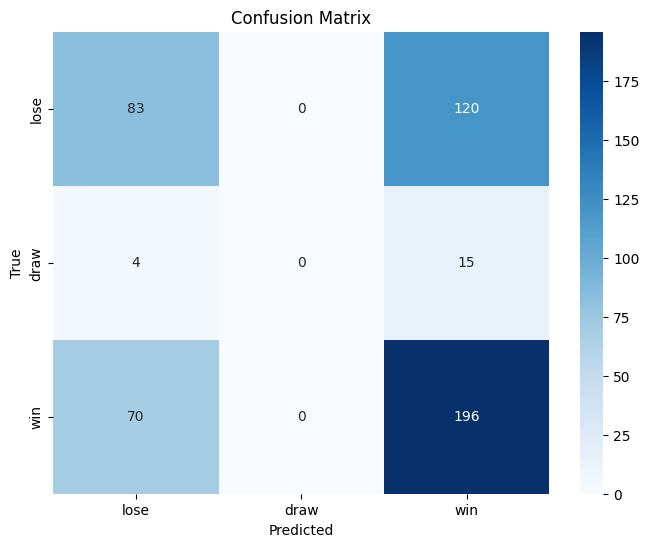

In [111]:
plot_confusion_matrix(y_F, y_pred, ["lose","draw","win"])

In [ ]:
LogisticRegression
RidgeClassifier
RidgeClassifierCV
LinearDiscriminantAnalysis()


In [123]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=2, verbose=2, scoring= 'f1_weighted')
grid_search.fit(X, y)

Fitting 2 folds for each of 729 candidates, totalling 1458 fits
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1,

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsa

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsa

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.001, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.001, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.001, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.001, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=100

[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.

[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsa

[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=5, min_child_weight=3, n_estimators=100

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=1.

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsa

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=5, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=5, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsa

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=100

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsa

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=100

[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=1.

[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsa

[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=1.

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, sub

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsam

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsa

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100], 'subsample': [0.6, 0.8, 1.0]},
             scoring='f1_weighted', verbose=2)

In [130]:
model = XGBClassifier(**grid_search.best_params_)

In [131]:
model_test(model, X, y, X_F, y_F, n=5)

{'Train': 0.5488639547177417,
 'Test': 0.5311294103339701,
 'Test_Final': 0.5619454316175628}

In [133]:
model.fit(X, y)
y_pred = model.predict(X_F)

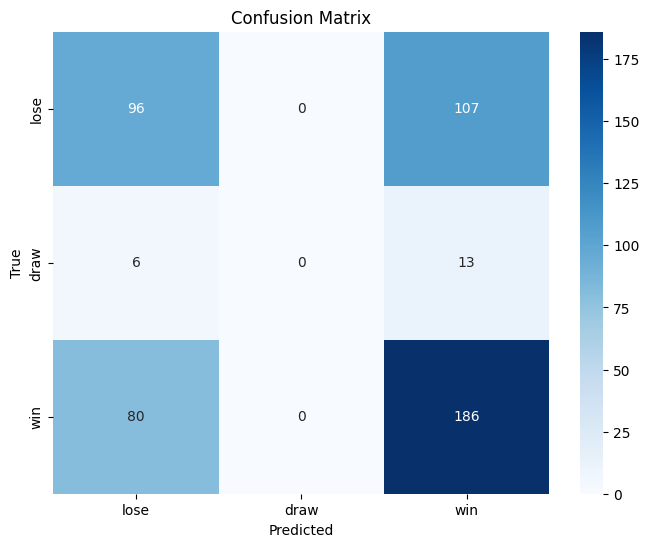

In [134]:
plot_confusion_matrix(y_F, y_pred, ["lose","draw","win"])